# House Sales Analysis for House Hocket 

## 0.0 Business Problem 

A House Rocket é uma plataforma digital que tem como modelo de negócio, a compra e a venda de imóveis usando tecnologia.
 
O CEO da House Rocket gostaria de maximizar a receita da empresa encontrando boas oportunidades de negócio.

Sua principal estratégia é comprar boas casas em ótimas localizações com preços baixos e depois revendê-las posteriormente à preços mais altos. Quanto maior a diferença entre a compra e a venda, maior o lucro da empresa e portanto maior sua receita.

Entretanto, as casas possuem muitos atributos que as tornam mais ou menos atrativas aos compradores e vendedores e a localização e o período do ano também podem influenciar os preços.

Portanto, seu trabalho como Data Scientist é responder as seguintes perguntas:

- Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?
- Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?
- A House Rocket deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?


Para responder essas perguntas, num primeiro momento farei uma boa análise exploratória dos dados, a fim de ganhar insights que além de responder alguma das perguntas, ajudará a enxergar outros pontos que talvez equipe de negócio não sabia antes. 

Posteriormente, será será ajustado um modelo linear para aderessar questões quantitativas, como o incremento de preço. 

O modelo linear foi escolhido, pois ele é paramétrico e parte de um problema de otimização, permitindo observar a importância de cada variável no incremento de preço (podemos saber quanto, em média, o preço aumenta por cada aumento da unidade da variável).

### 0.1 Dataset Features 

- **id** :a notation for a house

- **date**: Date house was sold

- **price**: Price is prediction target

- **bedrooms**: Number of Bedrooms/House

- **bathrooms**: Number of bathrooms/bedrooms

- **sqft_living**: square footage of the home

- **sqft_lot**: square footage of the lot

- **floors** :Total floors (levels) in house

- **waterfront** :House which has a view to a waterfront

- **view**: Has been viewed

- **condition** :How good the condition is Overall

- **grade**: overall grade given to the housing unit, based on King County grading system

- **sqft_above** :square footage of house apart from basement

- **sqft_basement**: square footage of the basement

- **yr_built** :Built Year

- **yr_renovated** :Year when house was renovated

- **zipcode**:zip code

- **lat**: Latitude coordinate

- **long**: Longitude coordinate

- **sqft_living15** :Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area

- **sqft_lot15** :lotSize area in 2015(implies-- some renovations)

Além desses dados, utilizaremos também dados do código postal de King County, que podem ser encontrados em: [King County Open Data](https://gis-kingcounty.opendata.arcgis.com/datasets/all-zipcodes-and-po-box-as-centroids-for-king-county-zipcode-all-point)

### 0.2 Imports

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.display       import Image
from IPython.core.display  import HTML

### 0.3 Helper Functions

In [107]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'seaborn-pastel' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_style('whitegrid')
    
def get_summary(numerical_attributes):
    
    # Central Tendency - mean, meadina 
    ct1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( numerical_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( numerical_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [108]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.4 Load Data

In [109]:
pre_df = pd.read_csv('../data/kc_house_data.csv', parse_dates = ['date'])
zip_df = pd.read_csv('../data/zipcodes.csv')

### 0.5 Merge Data

In [110]:
df_zip = zipcode[['ZIP', 'PREFERRED_CITY']]

In [111]:
df_zip.rename(columns = {'ZIP':'zipcode', 'PREFERRED_CITY':'city'}, inplace = True)

/home/jvbf/anaconda3/envs/house-sales/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [112]:
df = pd.merge(pre_df,df_zip,on = 'zipcode')

## 1.0 Describe Data

In [113]:
df1 = df.copy()

In [114]:
df1.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,7129300520,4060000240,4058801670,2976800796,6874200960,4268200055,3969300030,3969300030,1678400105,2172000075
date,2014-10-13 00:00:00,2014-06-23 00:00:00,2014-07-17 00:00:00,2014-09-25 00:00:00,2015-02-27 00:00:00,2015-05-01 00:00:00,2014-07-23 00:00:00,2014-12-29 00:00:00,2015-02-12 00:00:00,2014-06-23 00:00:00
price,221900.0000,205425.0000,445000.0000,236000.0000,170000.0000,245000.0000,165000.0000,239900.0000,339000.000,290900.0000
bedrooms,3,2,3,3,2,3,4,4,4,2
bathrooms,1.0000,1.0000,2.2500,1.0000,1.0000,1.7500,1.0000,1.0000,1.500,2.0000
sqft_living,1180,880,2100,1300,860,1740,1000,1000,2390,1610
sqft_lot,5650,6780,8201,5898,5265,11547,7134,7134,7480,17600
floors,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.500,2.0000
waterfront,0,0,0,0,0,0,0,0,0,0
view,0,0,2,0,0,0,0,0,2,0


In [115]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 22669
Number of Cols: 22


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22669 entries, 0 to 22668
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             22669 non-null  int64         
 1   date           22669 non-null  datetime64[ns]
 2   price          22669 non-null  float64       
 3   bedrooms       22669 non-null  int64         
 4   bathrooms      22669 non-null  float64       
 5   sqft_living    22669 non-null  int64         
 6   sqft_lot       22669 non-null  int64         
 7   floors         22669 non-null  float64       
 8   waterfront     22669 non-null  int64         
 9   view           22669 non-null  int64         
 10  condition      22669 non-null  int64         
 11  grade          22669 non-null  int64         
 12  sqft_above     22669 non-null  int64         
 13  sqft_basement  22669 non-null  int64         
 14  yr_built       22669 non-null  int64         
 15  yr_renovated   2266

In [117]:
cons = pd.DataFrame({'colunas' : df.columns,
                    'tipo': df.dtypes,
                    'missing' : df.isna().sum(),
                    'size' : df.shape[0],
                    'unicos': df.nunique()})

cons['percentual'] = round(cons['missing'] / cons['size'],2)

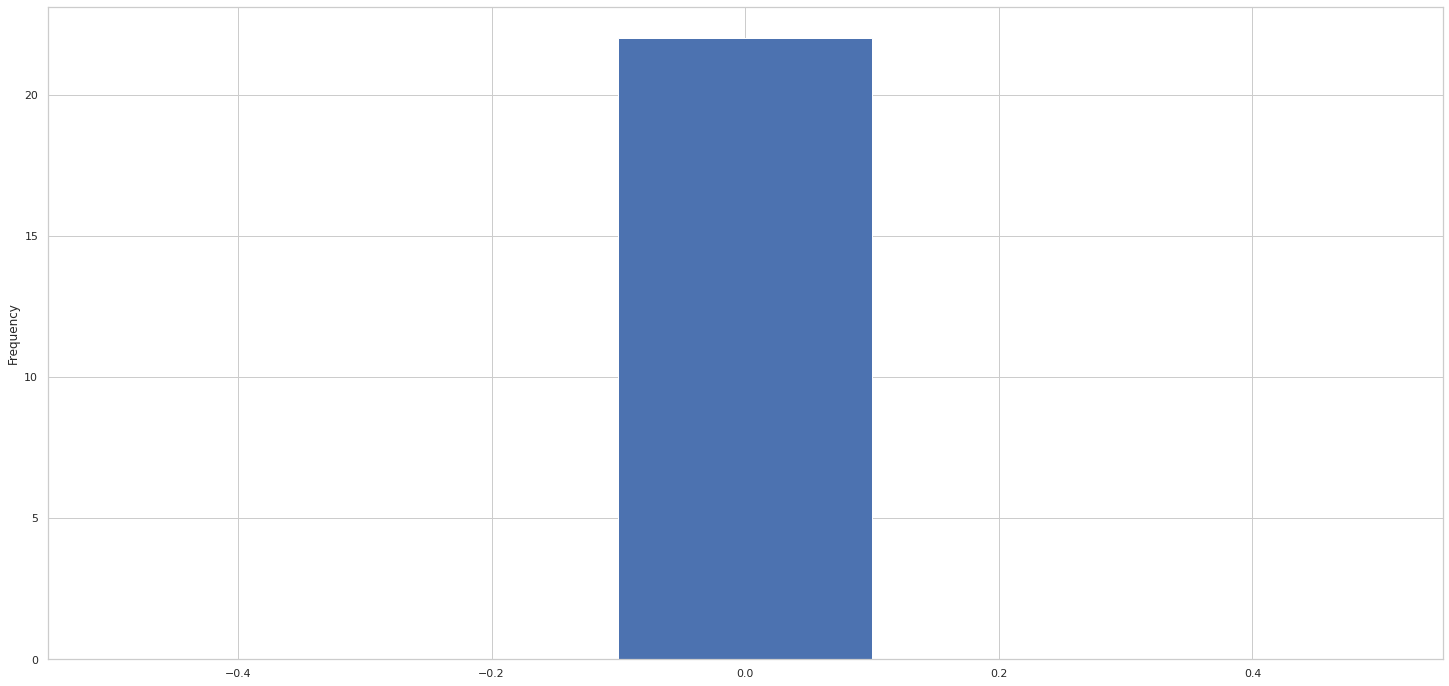

In [118]:
cons.percentual.plot.hist( bins = 5);

**Não existem dados faltantes no dataset**

In [119]:
df_aux = df1.drop(['id','date','lat','long', 'zipcode'], axis='columns')

num_attributes = df_aux.select_dtypes( include=['int64', 'float64'] )

In [120]:
get_summary(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.0,7700000.0,7625000.0,536201.260091,450000.00,362494.243969,4.024151,34.915778
1,bedrooms,0.0,33.0,33.0,3.373682,3.00,0.921593,1.936454,48.539051
2,bathrooms,0.0,8.0,8.0,2.119194,2.25,0.766044,0.494971,1.279914
3,sqft_living,290.0,13540.0,13250.0,2089.438264,1930.00,919.158330,1.453338,5.094978
4,sqft_lot,520.0,1651359.0,1650839.0,16520.716573,7708.00,45359.609179,12.513850,270.644290
5,floors,1.0,3.5,2.5,1.495236,1.50,0.537737,0.593451,-0.529538
6,waterfront,0.0,1.0,1.0,0.007190,0.00,0.084491,11.666142,134.110705
7,view,0.0,4.0,4.0,0.232785,0.00,0.763214,3.397306,10.894036
8,condition,1.0,5.0,4.0,3.409590,3.00,0.648924,1.034441,0.519031
9,grade,1.0,13.0,12.0,7.669549,7.00,1.178939,0.757885,1.152441


array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>],
       [<AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_above'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>]], dtype=object)

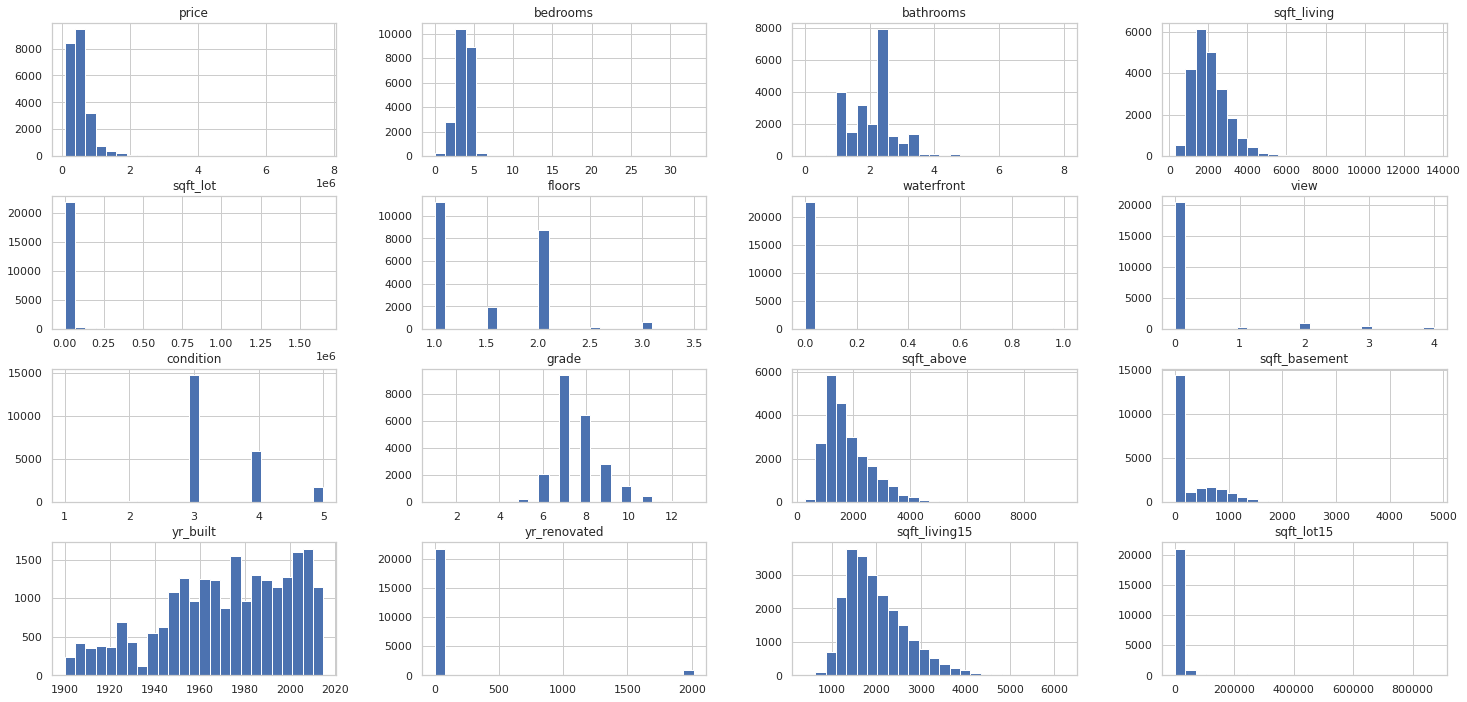

In [121]:
num_attributes.hist(bins = 25)

**Target**

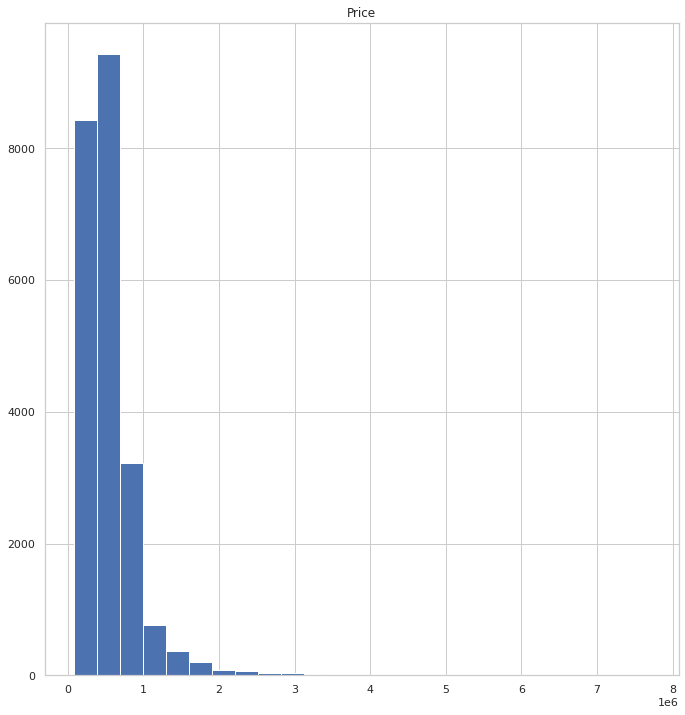

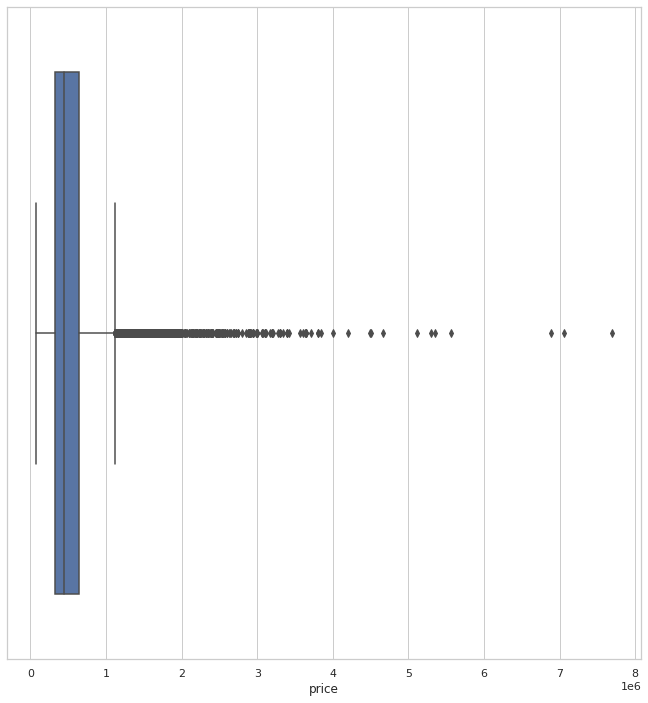

In [209]:
plt.subplot(1,2,1)
df['price'].hist(bins = 25)
plt.title('Price')
plt.show()

plt.subplot(1,2,2)
sns.boxplot(x = 'price', data = df);

**Categorical**

In [124]:
df1['waterfront'].value_counts()

0    22506
1      163
Name: waterfront, dtype: int64

In [125]:
df1['city'].value_counts()

SEATTLE          8977
RENTON           1597
BELLEVUE         1407
AUBURN           1263
KENT             1203
REDMOND           979
KIRKLAND          977
WOODINVILLE       942
FEDERAL WAY       779
ISSAQUAH          733
MAPLE VALLEY      590
ENUMCLAW          468
SAMMAMISH         441
SAMMAMIISH        359
SNOQUALMIE        310
KENMORE           283
MERCER ISLAND     282
NORTH BEND        221
BOTHELL           195
DUVALL            190
CARNATION         124
VASHON            118
BLACK DIAMOND     100
FALL CITY          81
MEDINA             50
Name: city, dtype: int64

## 2.0 Feature Engineering

In [126]:
df1 = df.copy()

### 2.1 Month and Year

In [127]:
df1['year'] = pd.DatetimeIndex(df['date']).year
df1['month'] = pd.DatetimeIndex(df['date']).month

In [128]:
month_dict = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Abr' , 5:'Mai', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Set', 10:'Out', 11:'Nov', 12:'Dez'}

df1['month'] = df1['month'].map(month_dict)

### 2.2 Basic Cleaning

In [129]:
city = []

for i in df1['city']:
    if i == 'SAMMAMIISH':
        city.append('SAMMAMISH')
    else:
        city.append(i)
    

In [130]:
df1['city'] = city

## 3.0 Exploratory Data Analysis

In [190]:
df2 = df1.copy()

### 3.1 Numerical Features

In [206]:
df2.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'city', 'year', 'month'],
      dtype='object')

<AxesSubplot:xlabel='view', ylabel='price'>

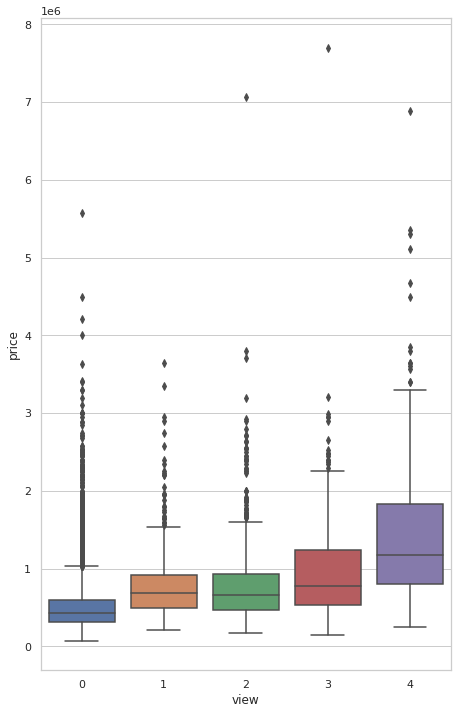

In [207]:
plt.subplot(1,3,1)
sns.boxplot(x = 'view', y = 'price', data = df2)

plt.subplot(1,3,1)

plt.subplot(1,3,1)



**Variação do preço por número de quartos, banheiros e andares**

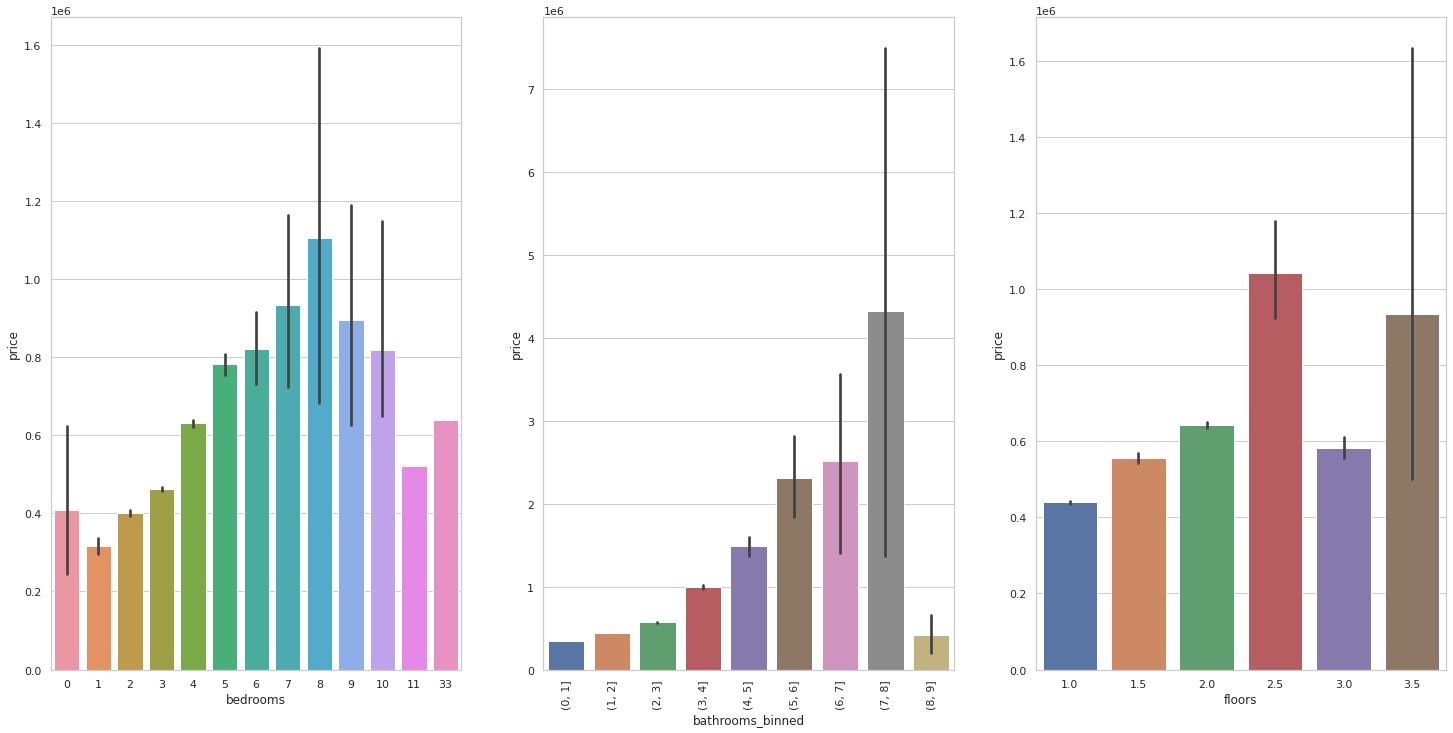

In [191]:
plt.subplot(1,3,1)
sns.barplot(x = 'bedrooms', y = 'price', data = df2)

plt.subplot(1,3,2)
bins = list( np.arange( 0, 10, 1))
aux1 = df2.copy()
aux1['bathrooms_binned'] = pd.cut( df2['bathrooms'], bins = bins )
sns.barplot(x = 'bathrooms_binned', y = 'price', data = aux1);
plt.xticks( rotation=90 );

plt.subplot(1,3,3)
sns.barplot(x = 'floors', y = 'price', data = df2);

In [192]:
df2['waterfront'] = df2['waterfront'].apply(lambda x: 'No' if x == 0 else 'Yes')
df2['waterfront'].value_counts()

No     22506
Yes      163
Name: waterfront, dtype: int64

**Waterfront**

<AxesSubplot:xlabel='price', ylabel='Density'>

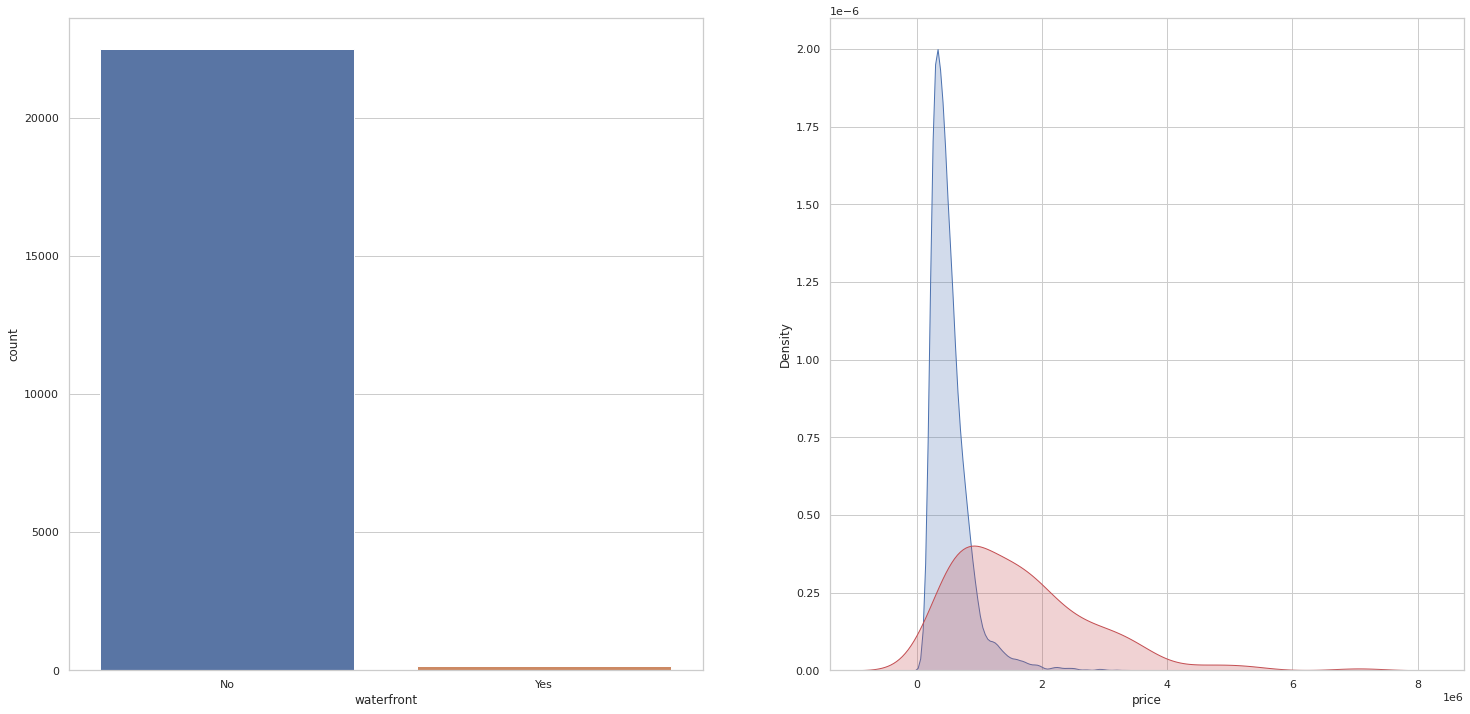

In [204]:
plt.subplot(1,2,1)
sns.countplot(x = 'waterfront', data = df2)

plt.subplot(1,2,2)
sns.kdeplot(df2[df2['waterfront']=='No']['price'],color='b',shade=True)
sns.kdeplot(df2[df2['waterfront']=='Yes']['price'],color='r',shade=True)

Residências na beira-mar, como esperado, são normalmente mais caras

**Square feet living / lot**

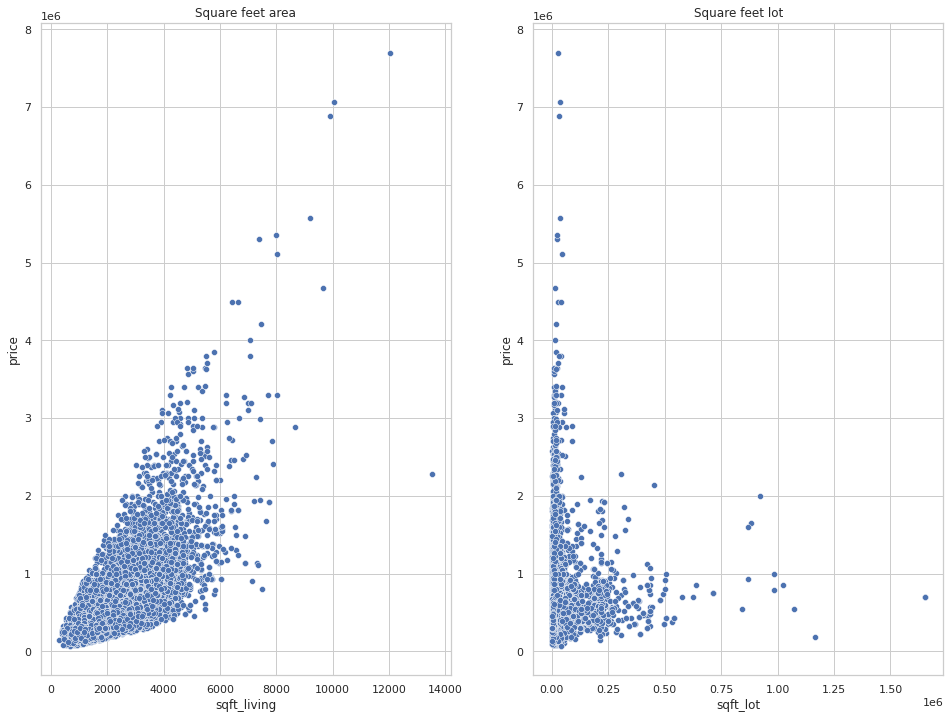

In [135]:
plt.subplot(1,3,1)
plt.title('Square feet area')
sns.scatterplot(x = 'sqft_living', y = 'price', data = df2)

plt.subplot(1,3,2)
plt.title('Square feet lot')
sns.scatterplot(x = 'sqft_lot', y = 'price', data = df2);

Há uma forte correlação positiva entre a área de casa e seu preço, porém, essa relação não é tão clara quando considerada a área do lote. 

**Sales and time**

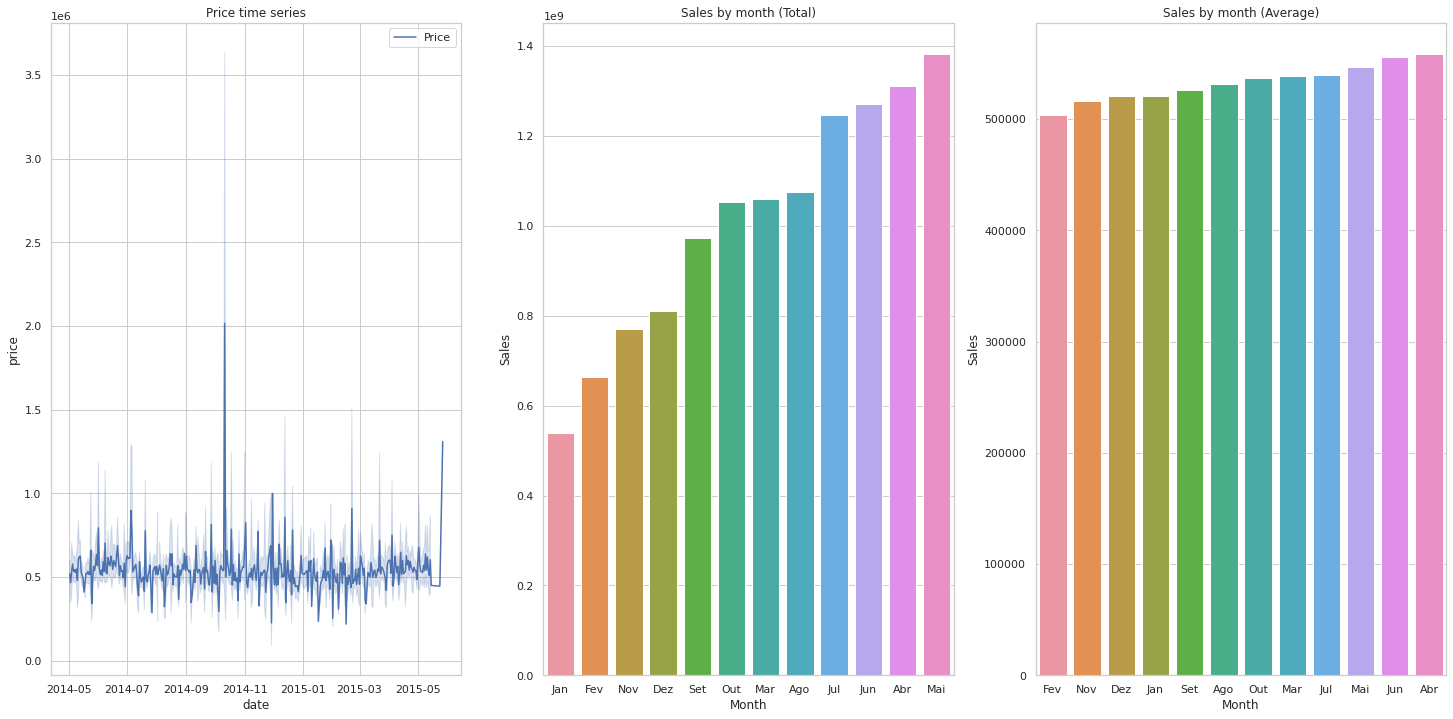

In [136]:
plt.subplot(1,3,1)
sns.lineplot( x='date', y='price', data=df2, label='Price' )
plt.title('Price time series')


plt.subplot(1,3,2)
aux2 = df2[['price', 'month']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='price', data=aux2.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Total)');

plt.subplot(1,3,3)
aux3 = df2[['price', 'month']].groupby('month').mean().reset_index()
sns.barplot( x='month', y='price', data=aux3.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Average)');

No varejo, normalmente as vendas são mais aquecidas no final do ano, nos mêses de Novembro e Dezembro. Vemos que o mercado de imóveis foge um pouco dessa regra, tendo **vendas médias maiores no começo para meio do ano, especificamente em Abril, Maio junho e Julho.** 

In [137]:
df2['month'].value_counts()

Mai    2525
Abr    2345
Jul    2307
Jun    2286
Ago    2023
Mar    1969
Out    1963
Set    1850
Dez    1557
Nov    1492
Fev    1318
Jan    1034
Name: month, dtype: int64

In [138]:
aux3.rename(columns = {'month':'Mês', 'price':'Média de vendas'}, inplace = True)
aux3.sort_values(by = ['Média de vendas'], ascending = False)

,Mês,Média de vendas
0,Abr,558631.645203
6,Jun,555899.642607
7,Mai,547393.763564
5,Jul,539937.047248
8,Mar,538439.869477
10,Out,536926.457463
1,Ago,531534.925358
11,Set,525954.615135
4,Jan,521003.038685
2,Dez,520462.845215


Alguns meses vendem menos, porém casas mais caras, o que, na média, faz com que todos os meses tenham um volume de venda aproximado, em torno de 500 mil por casa. Entretanto, **separaremos o dataset entre preços altos e baixos**, para tentar entender que mês vende casas mais caras ou mais baratas

In [139]:
df2['price'].describe()

count    2.266900e+04
mean     5.362013e+05
std      3.625022e+05
min      7.500000e+04
25%      3.200000e+05
50%      4.500000e+05
75%      6.400000e+05
max      7.700000e+06
Name: price, dtype: float64

Vemos que a mediana de preço é 450 mil dólares, valor que divide o conjunto de dados ordenados pelo preço ao meio. 

- 25% dos maiores valores são maiores que 645 mil dólares > **este será o conjunto de 'preços altos'**
- 25% dos menores valores são menores que 322 mil dólares > **este será o conjunto de 'preços baixos'**

In [140]:
aux_high_price = df2[df2['price'] > 644999] 
aux_high_price['price'].describe()

count    5.601000e+03
mean     9.809104e+05
std      4.697988e+05
min      6.450000e+05
25%      7.200000e+05
50%      8.250000e+05
75%      1.042030e+06
max      7.700000e+06
Name: price, dtype: float64

In [141]:
aux_low_price = df2[df2['price'] < 322000] 
aux_low_price['price'].describe()

count      5760.000000
mean     251691.558160
std       48059.769155
min       75000.000000
25%      220000.000000
50%      259000.000000
75%      290000.000000
max      321950.000000
Name: price, dtype: float64

**High Price**

Text(0.5, 1.0, 'Sales by month (Average)')

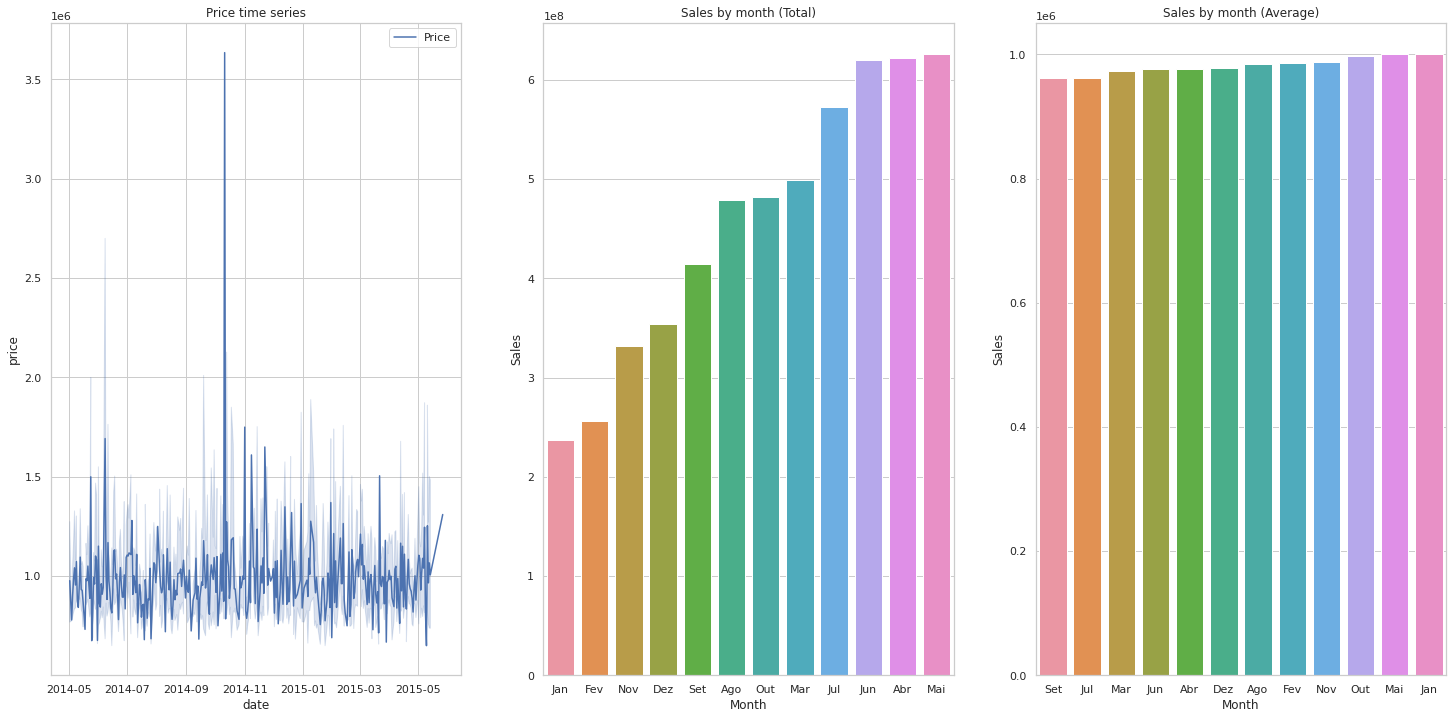

In [142]:
plt.subplot(1,3,1)
sns.lineplot( x='date', y='price', data=aux_high_price, label='Price' )
plt.title('Price time series')


plt.subplot(1,3,2)
aux2 = aux_high_price[['price', 'month']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='price', data = aux2.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Total)');

plt.subplot(1,3,3)
aux3 = aux_high_price[['price', 'month']].groupby('month').mean().reset_index()
sns.barplot( x='month', y='price', data = aux3.sort_values(['price']), label='Price' )
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales by month (Average)')

In [143]:
aux3.rename(columns = {'month':'Mês', 'price':'Média de vendas'}, inplace = True)
aux3.sort_values(by = ['Média de vendas'], ascending = False)

,Mês,Média de vendas
4,Jan,1.000604e+06
7,Mai,1.000109e+06
10,Out,9.974028e+05
9,Nov,9.876372e+05
3,Fev,9.865865e+05
1,Ago,9.848936e+05
2,Dez,9.774902e+05
0,Abr,9.762784e+05
6,Jun,9.761152e+05
8,Mar,9.733664e+05


Janeiro tem a menor quantidade de casas vendidas, porém, a segunda maior média de venda considerando as casas mais caras. Portanto, **Principalmente Janeiro**, mas também Fevereiro e Novembro tem comportamento parecido. 

### 3.2 Location 

In [144]:
df2['city'].value_counts()

SEATTLE          8977
RENTON           1597
BELLEVUE         1407
AUBURN           1263
KENT             1203
REDMOND           979
KIRKLAND          977
WOODINVILLE       942
SAMMAMISH         800
FEDERAL WAY       779
ISSAQUAH          733
MAPLE VALLEY      590
ENUMCLAW          468
SNOQUALMIE        310
KENMORE           283
MERCER ISLAND     282
NORTH BEND        221
BOTHELL           195
DUVALL            190
CARNATION         124
VASHON            118
BLACK DIAMOND     100
FALL CITY          81
MEDINA             50
Name: city, dtype: int64

**Total Sales / Average Sales by City**

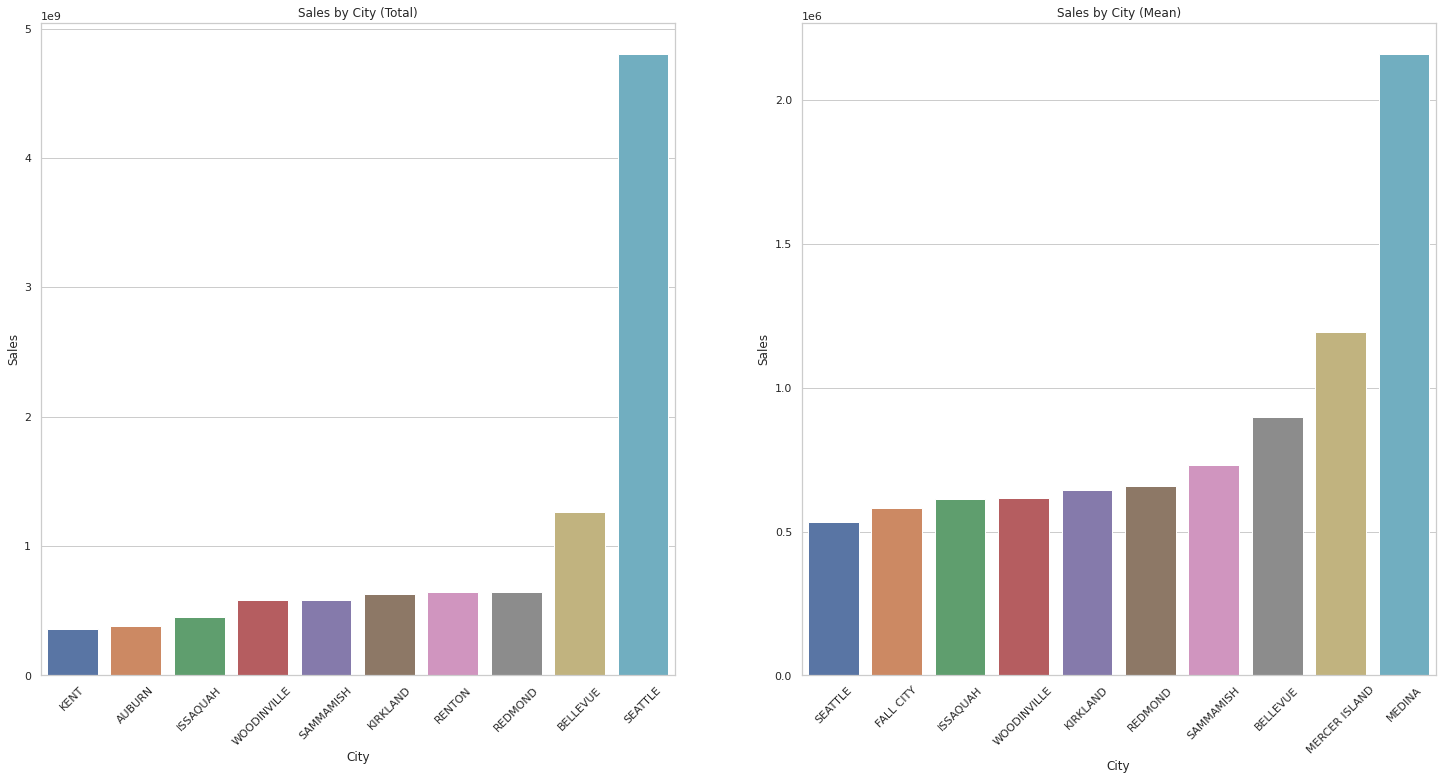

In [157]:
plt.subplot(1,2,1)
aux4 = df2[['price', 'city']].groupby('city').sum().reset_index()
sns.barplot( x='city', y='price', data= aux4.sort_values(['price']).tail(10), label='Price' )
plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Sales')
plt.title('Sales by City (Total)');

plt.subplot(1,2,2)
aux5 = df2[['price', 'city']].groupby('city').mean().reset_index()
sns.barplot( x='city', y='price', data= aux5.sort_values(['price']).tail(10), label='Price' )
plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Sales')
plt.title('Sales by City (Mean)');

In [159]:
aux5.rename(columns = {'city':'Cidade', 'price':'Média de vendas'}, inplace = True)
aux5.sort_values(by = ['Média de vendas'], ascending = False)

,Cidade,Média de vendas
14,MEDINA,2.160607e+06
15,MERCER ISLAND,1.194230e+06
1,BELLEVUE,8.981876e+05
19,SAMMAMISH,7.327115e+05
17,REDMOND,6.588548e+05
12,KIRKLAND,6.463742e+05
23,WOODINVILLE,6.173845e+05
9,ISSAQUAH,6.150913e+05
7,FALL CITY,5.805268e+05
20,SEATTLE,5.349638e+05
